# K-Means Clustering: From Intuition to Application

This notebook provides a comprehensive guide to the K-Means clustering algorithm. We'll start with the high-level intuition, walk through the core mechanics step-by-step, build the algorithm from scratch, and finally, apply it to a real-world dataset to discover hidden customer segments.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Set plotting style
sns.set_style('whitegrid')

## 🛒 Section 1: Automatically Sorting the Data Pile (An Introduction to K-Means)

### What is K-Means? (The "Customer Segmentation" Analogy)

Imagine you're a data scientist for a wholesale distributor. You have spending data for hundreds of customers across various product categories like 'Fresh', 'Milk', 'Grocery', etc. Your manager wants to understand the customer base better to create targeted marketing campaigns. The challenge is, you have no pre-existing labels like 'small cafe' or 'large retailer'.

This is where K-Means comes in. It's an algorithm that automatically finds natural groupings (clusters) in your data. You tell it how many groups (`K`) you want to find, and it partitions the customers into `K` distinct segments. Each segment will contain customers with similar purchasing behaviors, allowing you to answer the question: "What kinds of customer archetypes do we have?"

### Algorithm Type: Unsupervised Learning
K-Means is a cornerstone of **unsupervised learning**. The term "unsupervised" means we don't provide the algorithm with the "right answers." We don't have a target variable or label (`y`) to predict. Instead, the goal is to explore the data and discover its inherent structure. The primary task here is **clustering**—grouping similar data points together.

## 🧠 Section 2: Core Mechanics & Terminology

To understand how K-Means works, we need to define a few key terms. We'll use a simple, synthetic dataset of "blobs" to make these concepts crystal clear.

First, let's generate a dataset with 3 distinct, well-separated blobs. This is the ideal scenario for K-Means.

In [2]:
X_blobs, y_blobs = make_blobs(n_samples=300, centers=3, cluster_std=1.0, random_state=42)

Now, let's visualize this synthetic data.

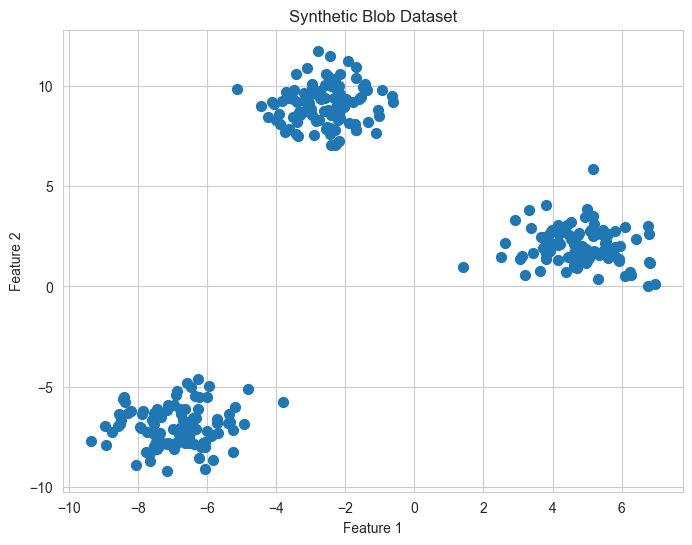

In [3]:
plt.figure(figsize=(8, 6))
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], s=50)
plt.title('Synthetic Blob Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### Key Terms
- **Clusters:** The final groups of data points (customers) that the algorithm identifies. In our plot above, we can visually see 3 distinct clusters.
- **Centroids:** The center of each cluster. The "mean" in "K-Means" refers to the fact that this centroid is the arithmetic mean of all the points in its cluster. It represents the "average" data point for that group.
- **Inertia (Within-Cluster Sum of Squares - WCSS):** This is the objective function that K-Means aims to minimize. It is the sum of the squared distances between each data point and its assigned cluster's centroid. A lower inertia means the clusters are more compact and the points within each cluster are closer to their center.

The formula for WCSS is:
$$ WCSS = \sum_{j=1}^{K} \sum_{i \in C_j} \|x_i - \mu_j\|^2 $$

Where:
- $K$ is the number of clusters.
- $C_j$ is the set of all points in cluster $j$.
- $x_i$ is a data point.
- $\mu_j$ is the centroid of cluster $j$.

## ⚙️ Section 3: The K-Means Algorithm in Action (A Step-by-Step Walkthrough)

K-Means finds the best centroids by iteratively repeating two simple steps. Let's walk through this process for our blobs dataset with $K=3$.

#### **Step 1: Initialization**
The algorithm begins by placing `K` centroids in the feature space. A naive approach is to place them randomly. However, a much smarter and more common method is **k-means++**. This method intelligently places the initial centroids far away from each other, which leads to faster convergence and more consistent results.

#### **Step 2: The Assignment Step**
For every data point in the dataset, calculate its Euclidean distance to each of the `K` centroids. Then, assign the data point to the cluster of the **nearest** centroid.

#### **Step 3: The Update Step**
After all points have been assigned to a cluster, recalculate the position of each of the `K` centroids. The new position of a centroid is the mean (i.e., the average position) of all the data points assigned to it in the previous step. This is the step that moves the centroid to the center of its new cluster.

#### **Step 4: Iteration & Convergence**
Repeat the **Assignment Step** and the **Update Step** iteratively.
The algorithm has **converged** when the assignments of data points to clusters no longer change, which means the centroids have stopped moving. At this point, the algorithm has found a stable solution (a local minimum for the inertia).

## 🛠️ Section 4: Building K-Means from Scratch (Pure Python)

To truly understand the algorithm, let's implement it from scratch. Our goal is to create a Python class that performs the initialization, assignment, and update loop we just described.

We will define a `SimpleKMeans` class. Its `fit` method will contain the main loop that iterates until the centroids stabilize.

In [4]:
class SimpleKMeans:
    def __init__(self, K=3, max_iters=100):
        self.K = K
        self.max_iters = max_iters
        self.centroids = None

    def _initialize_centroids(self, X):
        """Randomly initialize centroids from the data points."""
        np.random.seed(42)
        random_indices = np.random.permutation(X.shape[0])
        self.centroids = X[random_indices[:self.K]]
    
    def _assign_clusters(self, X):
        """Assign each data point to the closest centroid."""
        distances = np.zeros((X.shape[0], self.K))
        for k in range(self.K):
            # Calculate Euclidean distance from each point to the k-th centroid
            distances[:, k] = np.linalg.norm(X - self.centroids[k], axis=1)
        # Assign cluster label based on the minimum distance
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X, labels):
        """Update centroids to be the mean of assigned points."""
        new_centroids = np.zeros((self.K, X.shape[1]))
        for k in range(self.K):
            new_centroids[k, :] = np.mean(X[labels == k, :], axis=0)
        return new_centroids

    def fit(self, X):
        """The main loop for the K-Means algorithm."""
        self._initialize_centroids(X)
        
        for i in range(self.max_iters):
            labels = self._assign_clusters(X)
            old_centroids = self.centroids
            self.centroids = self._update_centroids(X, labels)
            
            # Check for convergence
            if np.all(old_centroids == self.centroids):
                print(f"Converged after {i+1} iterations.")
                break
        return labels

Now, let's apply our `SimpleKMeans` implementation to the synthetic blobs data.

In [5]:
# Instantiate and fit the model
simple_kmeans = SimpleKMeans(K=3)
labels_scratch = simple_kmeans.fit(X_blobs)
centroids_scratch = simple_kmeans.centroids

Converged after 3 iterations.


Finally, let's visualize the results. We'll plot the data points colored by their new cluster labels and mark the final centroids.

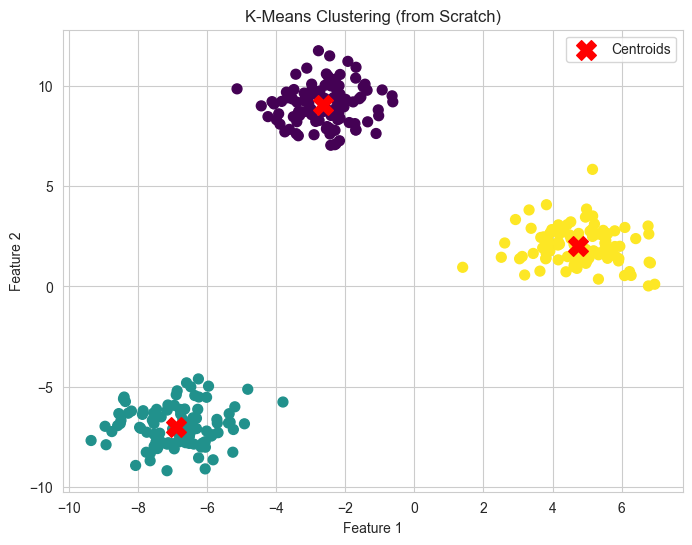

In [6]:
plt.figure(figsize=(8, 6))
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=labels_scratch, s=50, cmap='viridis')
plt.scatter(centroids_scratch[:, 0], centroids_scratch[:, 1], c='red', s=200, marker='X', label='Centroids')
plt.title('K-Means Clustering (from Scratch)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

## ⚠️ Section 5: Crucial Practical Considerations

While K-Means is simple, using it effectively requires awareness of a few key details.

### Feature Scaling: A Mandatory Step!

K-Means is a distance-based algorithm. This means that features with larger scales (e.g., values from 10,000 to 100,000) will completely dominate features with smaller scales (e.g., values from 1 to 100). The distances will be almost entirely determined by the larger-scale feature.

**Connection to Data:** When we use the **Wholesale Customers dataset** later, we'll see that spending on 'Fresh' products can be in the tens of thousands, while spending on 'Detergents_Paper' is often in the hundreds. Without scaling, the 'Fresh' category would overwhelm the clustering process. Therefore, **it is mandatory to scale your features (e.g., using `StandardScaler`) before applying K-Means**.

### Sensitivity to Initialization

The initial random placement of centroids can sometimes lead to different final clusterings. A poor initialization might cause the algorithm to converge on a suboptimal solution (a local minimum with higher inertia). 

To combat this, scikit-learn's `KMeans` implementation has a parameter called `n_init`. By default, `n_init=10`, which means it runs the entire algorithm 10 times with different random initializations and automatically returns the best result (the one with the lowest inertia).

### Cluster Shape Assumption

K-Means implicitly assumes that clusters are **spherical** (convex) and roughly the same size. It works by finding a center and expanding a circle around it. This means it can fail on datasets with complex, non-spherical shapes.

Let's create a dataset of two concentric circles to illustrate this limitation.

In [7]:
X_moons, y_moons = make_moons(n_samples=300, noise=0.05, random_state=42)

Now we apply `KMeans` with `K=2` and visualize how it incorrectly tries to partition this non-spherical data.

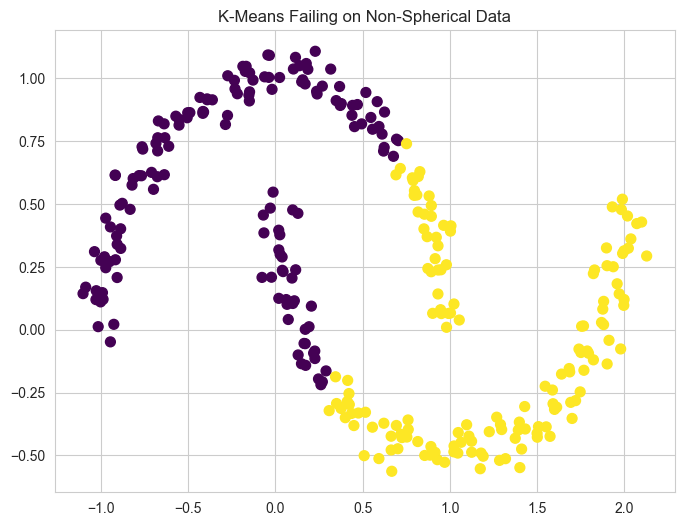

In [16]:
kmeans_moons = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_moons = kmeans_moons.fit_predict(X_moons)

plt.figure(figsize=(8, 6))
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=labels_moons, s=50, cmap='viridis')
plt.title('K-Means Failing on Non-Spherical Data')
plt.show()

As you can see, K-Means simply cuts the data in half, failing to identify the two moon-shaped clusters. For this kind of data, other algorithms like DBSCAN or Spectral Clustering would be more appropriate.

## 🎯 Section 6: Finding the Optimal "K" for Customer Segmentation

This is the most critical question in any clustering project: **How many clusters (`K`) should we use?** We will explore this using the **Wholesale Customers dataset**.

First, let's load and inspect the data.

In [17]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
df = pd.read_csv(url)
df.drop(['Channel', 'Region'], axis=1, inplace=True) # Dropping categorical for simplicity

print("First 5 rows of the dataset:")
display(df.head())
print("\nDataset Information:")
df.info()

First 5 rows of the dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Fresh             440 non-null    int64
 1   Milk              440 non-null    int64
 2   Grocery           440 non-null    int64
 3   Frozen            440 non-null    int64
 4   Detergents_Paper  440 non-null    int64
 5   Delicassen        440 non-null    int64
dtypes: int64(6)
memory usage: 20.8 KB


As discussed, we must scale the data before applying K-Means. We will use `StandardScaler` to give each feature a mean of 0 and a standard deviation of 1.

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

### The Elbow Method

The Elbow Method is a popular heuristic for finding the optimal `K`. We run K-Means for a range of `K` values (e.g., from 1 to 10) and plot the inertia (WCSS) for each run. We look for the "elbow" in the plot—the point where the rate of decrease in inertia sharply slows down. This point suggests a good trade-off between the number of clusters and the compactness of those clusters.

In [23]:
inertia_values = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)


Now we plot the inertia values against the number of clusters.

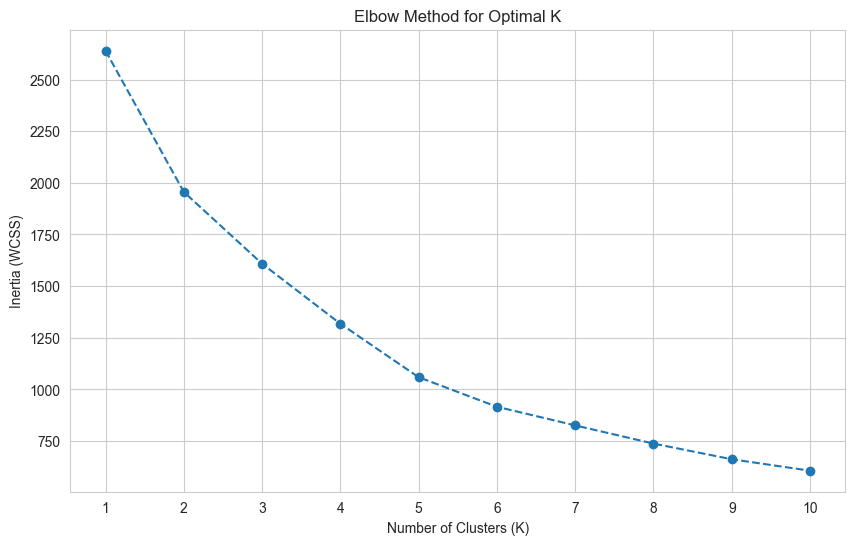

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (WCSS)')
plt.xticks(k_range)
plt.show()

The "elbow" appears to be around K=4 or K=5, where adding another cluster provides diminishing returns (i.e., doesn't decrease inertia by much). Let's use a more robust metric to confirm this.

### The Silhouette Score

The Silhouette Score is a more formal metric that evaluates how well-defined the clusters are. It provides a score for each data point based on two criteria:
- **Cohesion ($a$):** How similar a point is to other points in its own cluster (mean intra-cluster distance).
- **Separation ($b$):** How different a point is from points in the nearest neighboring cluster (mean nearest-cluster distance).

The score is calculated as $(b - a) / \max(a, b)$ and ranges from -1 to +1. A score near +1 is best, indicating dense and well-separated clusters. We will calculate the average silhouette score for different values of `K`.

In [ ]:
silhouette_scores = []
k_range_sil = range(2, 11) # Silhouette score requires at least 2 clusters

for k in k_range_sil:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)


Let's plot the silhouette scores.

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(k_range_sil, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Silhouette Score')
plt.xticks(k_range_sil)
plt.show()

The silhouette score peaks at **K=5**, suggesting this is the most appropriate number of customer segments for our data. It provides a stronger justification than the visual inspection of the elbow plot.

### Visualizing the Clusters with PCA

Our customer data has 6 dimensions (Fresh, Milk, Grocery, etc.), so we can't create a simple 2D scatter plot to see our clusters. To visualize them, we must first reduce the dimensionality of the data.

**Principal Component Analysis (PCA)** is a dimensionality reduction technique that can transform our 6-dimensional data into 2 "principal components" that capture the most variance in the data. We can then plot these 2 components to see our customer segments.

First, we run K-Means with our optimal K=5.

In [ ]:
optimal_k = 5
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
final_labels = kmeans_final.fit_predict(X_scaled)

Next, we apply PCA to the scaled data to get 2 principal components.

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

Finally, we create a scatter plot of the two principal components, coloring the points by their assigned cluster label. This gives us a powerful visual confirmation of our customer segments.

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=final_labels, palette='viridis', s=100, alpha=0.8)
plt.title('Customer Segments Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Customer Segment')
plt.show()

## ✅ Section 7: Conclusion & Summary

In this notebook, we took a deep dive into K-Means clustering. We started with the core intuition and saw how its simple, iterative process of assigning points and updating centroids can find hidden groups in unlabeled data. We implemented the algorithm from scratch to solidify our understanding and discussed crucial practical considerations like feature scaling and its sensitivity to cluster shape.

Finally, we applied K-Means to a real-world business problem, using the Elbow Method and Silhouette Score to determine the optimal number of customer segments. Using PCA, we were able to visualize these high-dimensional segments in a 2D plot, turning an abstract clustering result into an actionable business insight.

### Strengths & Weaknesses Summary

**Strengths 👍:**
- **Fast and Scalable:** Computationally efficient and works well on large datasets.
- **Simple to Implement:** The core logic is easy to understand and code.
- **Easy to Interpret:** The resulting clusters and their centroids are straightforward to analyze.

**Weaknesses 👎:**
- **Must Specify `K`:** Requires the number of clusters to be chosen beforehand.
- **Sensitive to Initialization:** Can converge to a suboptimal solution if not run multiple times (`n_init`).
- **Sensitive to Outliers:** Outliers can significantly pull centroids, distorting the clusters.
- **Struggles with Non-Spherical Clusters:** Assumes clusters are convex and isotropic, failing on complex shapes.